## Intelligent Systems - HW2
### Soroush Mesforush Mashhad
#### SID: 810198472

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
import random

In [2]:
Train = pd.read_csv('titanic-train.csv')
Test = pd.read_csv('titanic-test.csv')

In [3]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Embarked  889 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [4]:
Train['Survived'].sum()

342

In [5]:
Train.insert(8, 'label', list(Train['Survived']))
Train.drop(['Survived'], axis=1, inplace=True)
Train.head()

,Pclass,Embarked,Sex,Age,SibSp,Parch,Fare,label
0,3,S,male,22.0,1,0,7.2500,0
1,1,C,female,38.0,1,0,71.2833,1
2,3,S,female,26.0,0,0,7.9250,1
3,1,S,female,35.0,1,0,53.1000,1
4,3,S,male,35.0,0,0,8.0500,0


In [6]:
Train = Train.drop(['Embarked', 'Fare'], axis=1)
Train['Age'] = Train['Age'].fillna(Train['Age'].mean())
Train['Sex'] = Train['Sex'].map({'male': 0, 'female': 1})
Train.head()

,Pclass,Sex,Age,SibSp,Parch,label
0,3,0,22.0,1,0,0
1,1,1,38.0,1,0,1
2,3,1,26.0,0,0,1
3,1,1,35.0,1,0,1
4,3,0,35.0,0,0,0


In [7]:
Train.isna().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
label     0
dtype: int64

In [8]:
Features = ['categorical', 'categorical', 'continuous', 'continuous', 'continuous', 'categorical']

In [9]:
def PureData(data):
    ColLabel = data[:, -1]
    UniqueClasses = np.unique(ColLabel)

    if len(UniqueClasses) == 1:
        return True
    else:
        return False

In [10]:
def DataClassification(data):
    ColLabel = data[:, -1]
    UniqueClasses, NumberUniqueClasses = np.unique(ColLabel, return_counts=True)
    index = NumberUniqueClasses.argmax()
    Classification = UniqueClasses[index]
    
    return Classification

In [11]:
def PotentialSplitting(data):
    PotSplit = {}
    _, n_columns = data.shape
    for ColInd in range(n_columns - 1):
        Vals = data[:, ColInd]
        UniqueVals = np.unique(Vals)
        
        PotSplit[ColInd] = UniqueVals
    
    return PotSplit

In [12]:
def DataSplitting(data, ColSplit, SplitVal):
    
    FeatureType = Features[ColSplit]
    ColSplitVal = data[:, ColSplit]

    if FeatureType == "continuous":
        DataM = data[ColSplitVal <= SplitVal]
        DataP = data[ColSplitVal >  SplitVal]
    
    else:
        DataM = data[ColSplitVal == SplitVal]
        DataP = data[ColSplitVal != SplitVal]
    
    return DataM, DataP

In [13]:
def EntropyCal(data):
    ColLabel = data[:, -1]
    _, counts = np.unique(ColLabel, return_counts=True)

    Probs = counts / counts.sum()
    Entropy = sum(Probs * -np.log2(Probs))
     
    return Entropy

In [14]:
def OverallEntropyCal(DataM, DataP):
    n = len(DataM) + len(DataP)
    p_DataM = len(DataM) / n
    p_DataP = len(DataP) / n

    OverallEntropy =(p_DataM * EntropyCal(DataM)+ p_DataP * EntropyCal(DataP))
    
    return OverallEntropy

In [15]:
def BestSplitChoice(data, PotSplit):
    OverallEntropy = np.iinfo(np.int32).max
    for ColInd in PotSplit:
        for Val in PotSplit[ColInd]:
            DataM, DataP = DataSplitting(data, ColSplit=ColInd, SplitVal=Val)
            OverallEntropyNow = OverallEntropyCal(DataM, DataP)

            if OverallEntropyNow <= OverallEntropy:
                OverallEntropy = OverallEntropyNow
                ColSplitBest = ColInd
                SplitValBest = Val
    
    return ColSplitBest, SplitValBest

In [16]:
def ID3(df, counter=0, MinSamples=2, MaxDepth=5):
    global ColHead, Features
    if counter == 0:
        ColHead = df.columns
        data = df.values
    else:
        data = df           
    
    if (PureData(data)) or (len(data) < MinSamples) or (counter == MaxDepth):
        classification = DataClassification(data)
        
        return classification
    
    else:    
        counter += 1

        PotSplit = PotentialSplitting(data)
        ColSplit, SplitVal = BestSplitChoice(data, PotSplit)
        DataM, DataP = DataSplitting(data, ColSplit, SplitVal)
        
        if len(DataM) == 0 or len(DataP) == 0:
            classification = DataClassification(data)
            return classification
         
        feature_name = ColHead[ColSplit]
        FeatureType = Features[ColSplit]
        if FeatureType == "continuous":
            Query = "{} <= {}".format(feature_name, SplitVal)
            
        else:
            Query = "{} = {}".format(feature_name, SplitVal)
        
        sub_tree = {Query: []}
        
        PosAns = ID3(DataM, counter, MinSamples, MaxDepth)
        NegAns = ID3(DataP, counter, MinSamples, MaxDepth)
        
        if PosAns == NegAns:
            sub_tree = PosAns
        else:
            sub_tree[Query].append(PosAns)
            sub_tree[Query].append(NegAns)
        
        return sub_tree

In [17]:
def PredictExpl(example, tree):
    if not isinstance(tree, dict):
        return tree
    
    Query = list(tree.keys())[0]
    feature_name, CompOP, value = Query.split(" ")

    if CompOP == "<=":
        if example[feature_name] <= float(value):
            ANS = tree[Query][0]
        else:
            ANS = tree[Query][1]
    
    else:
        if str(example[feature_name]) == value:
            ANS = tree[Query][0]
        else:
            ANS = tree[Query][1]

    if not isinstance(ANS, dict):
        return ANS
    
    else:
        residual_tree = ANS
        return PredictExpl(example, residual_tree)

In [18]:
def MakePreds(df, tree):
    if len(df) != 0:
        Preds = df.apply(PredictExpl, args=(tree,), axis=1)
    else:
        Preds = pd.Series()
    return Preds

In [19]:
def calculate_accuracy(df, tree):
    Preds = MakePreds(df, tree)
    PredsCorrect = Preds == df.label
    ACC = PredsCorrect.mean()
    return ACC

In [20]:
def random_forest(Train, Test, k=5):
    preds = []
    trees = []
    results = []
    for i in range(k):
        Test_ = Train.sample(frac=0.2, random_state=random.randint(0, 2000))
        idx = Test_.index
        Train = Train.iloc[list(set(range(len(Train)))-set(idx)), :]
        tree = ID3(Train, MaxDepth=3)
        trees.append(tree)
    for i, row in Test.iterrows():
        for tree in trees:
            predictions = PredictExpl(row, tree)
            preds.append(predictions)
        results.append(max(set(preds), key = preds.count))
        preds = []
    return np.array(results)

In [50]:
Test = Train.sample(frac=0.2,random_state=42)
idx = Test.index
Train_ = Train.iloc[list(set(range(len(Train)))-set(idx)), :]
tree = ID3(Train_, MaxDepth=3)
print(tree)

{'Sex = 1.0': [{'Pclass = 3.0': [{'SibSp <= 2.0': [1.0, 0.0]}, {'Age <= 2.0': [0.0, 1.0]}]}, {'Age <= 6.0': [{'SibSp <= 2.0': [1.0, 0.0]}, 0.0]}]}


In [51]:
calculate_accuracy(Test, tree)

0.797752808988764

In [52]:
def CMatrix(Pred,Real):
    #First we must find the classes, i.e: 0 1 2
    Cls = np.unique(Real)
    Len  = len(Cls)
    #We know that the confusion matrix is always a square matrix hence
    Cm = np.zeros((Len,Len))
    for i in range (Len):
        for j in range(Len):
            Cm[i][j] = np.sum((Real == Cls[i]) & (Pred == Cls[j]))
    return Cm

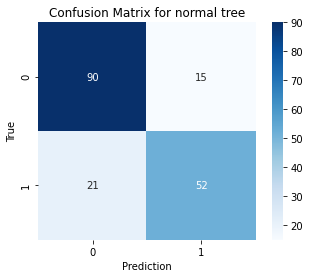

In [53]:
predictions = MakePreds(Test, tree)
Cm=CMatrix(predictions, Test.label)
ax = sn.heatmap(Cm,cmap="Blues" ,annot=True,square = True)
plt.title('Confusion Matrix for normal tree')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [57]:
tree = ID3(Train_, MaxDepth=5)
print(tree)

{'Sex = 1.0': [{'Pclass = 3.0': [{'SibSp <= 2.0': [{'Parch <= 3.0': [1.0, 0.0]}, {'Parch <= 0.0': [1.0, 0.0]}]}, {'Age <= 2.0': [{'Parch <= 1.0': [1.0, 0.0]}, 1.0]}]}, {'Age <= 6.0': [{'SibSp <= 2.0': [1.0, 0.0]}, {'Pclass = 1.0': [{'Age <= 70.0': [0.0, 1.0]}, 0.0]}]}]}


In [58]:
calculate_accuracy(Test, tree)

0.7865168539325843

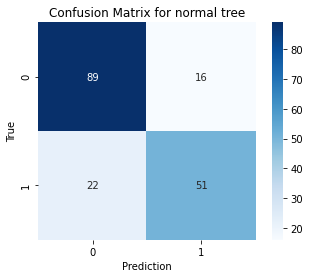

In [59]:
predictions = MakePreds(Test, tree)
Cm=CMatrix(predictions, Test.label)
ax = sn.heatmap(Cm,cmap="Blues" ,annot=True,square = True)
plt.title('Confusion Matrix for normal tree')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [65]:
predictions = random_forest(Train_, Test, 9)

In [66]:
print("Accuracy =", (np.array(predictions) == Test.label).mean())

Accuracy = 0.8146067415730337


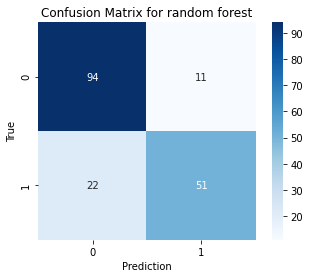

In [67]:
Cm=CMatrix(predictions, Test.label)
ax = sn.heatmap(Cm,cmap="Blues" ,annot=True,square = True)
plt.title('Confusion Matrix for random forest')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()